# EDA
In this notebook, I will take a look at the data and make reasonable adjustments and engineering to features. Feature engineering is integrated into this process.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import pickle

pd.set_option('precision', 4)
pd.options.display.max_seq_items = None
pd.options.display.max_columns = 50

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df = pd.read_pickle('PKL/clean_df.pkl')

In [3]:
df.head(2)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.9381,-9.8563,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.6988,-2.1475,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,True,GeoData Consultants Ltd,Other,None,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


## Data Types
### ID
ID is not a relevant predictor, I will remove this column.

In [4]:
# I'll add them to colstodrop list and drop all at once later
colstodrop = ['id']

### Dates
Since time since is probably important, I'll make these as a continuous integer.  
I will also create a year_recorded column to later engineer the age of the waterpoint.

In [5]:
# separate dates
df['year_recorded'] = [int(x[0:4]) for x in df.date_recorded]
df['date_recorded'] = [int(x.replace('-', '')) for x in df.date_recorded]

### Region code & District code
Even though they are integers, they should be objects. I'll change their filetypes.

In [6]:
# convert region_code and district_code to be objects.
df['region_code'] = df.region_code.astype('object')
df['district_code'] = df.district_code.astype('object')

## Target Variables
Let's see how our target variable is distributed.

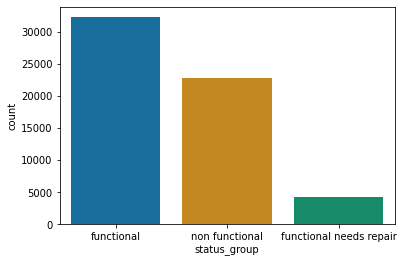

In [7]:
sns.countplot(df.status_group, palette = 'colorblind')
plt.show()

In [8]:
df.status_group.value_counts(normalize = True)

functional                 0.5431
non functional             0.3842
functional needs repair    0.0727
Name: status_group, dtype: float64

Our target variable has some class imbalance issue. 
More than half of our training data are fully functional, while less than 10% are functional but requires repair.

# Continuous variables
I'll take a look at the continuous variables first.

## Total Static Head

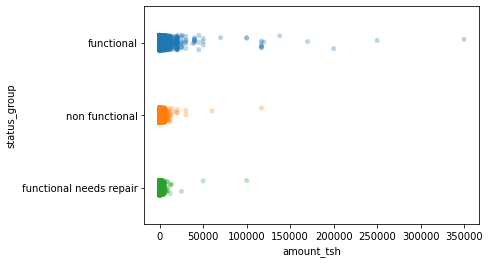

In [9]:
sns.stripplot(x = 'amount_tsh', y = 'status_group', data = df, 
             alpha = 0.3)
plt.show()

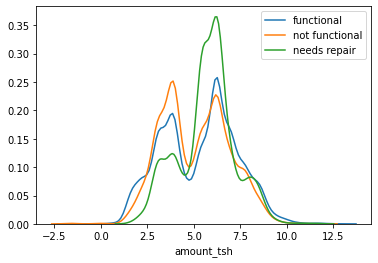

In [10]:
tmp = df[df.amount_tsh!=0]
sns.distplot(np.log(tmp[tmp.status_group == 'functional'].amount_tsh), hist = False, 
            label='functional')
sns.distplot(np.log(tmp[tmp.status_group == 'non functional'].amount_tsh), hist = False, 
            label = 'not functional')
sns.distplot(np.log(tmp[tmp.status_group == 'functional needs repair'].amount_tsh), hist = False, 
            label = 'needs repair')

plt.legend(bbox_to_anchor = [1, 1])
plt.show()
                 

Most values are very small with a few high extreme values. These high value would impact our model. But since the unit information is not present, I cannot figure out if these outliers are error or not. Normalizing these values show a bit of bimodal look.

## Altitude of the well (gps_height)


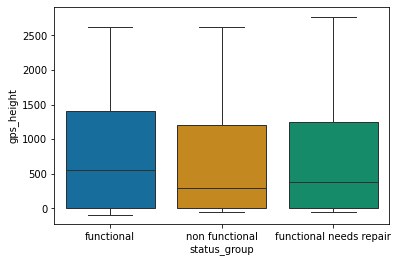

In [11]:
sns.boxplot(x = 'status_group', y = 'gps_height', 
            data = df, linewidth = 1, palette = 'colorblind')
plt.show()

There are some negative altitude, which probably means that the well goes below the sea level. This could have an implication. I should consider adding a binary feature to show this. Also many are 0, this is also possibly missing values, but later I should check how it affects the model by adding a binary column as well.

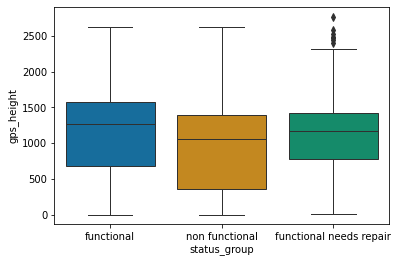

In [12]:
# without negative or zero values
sns.boxplot(x = 'status_group', y = 'gps_height', 
            data = df[df.gps_height > 0], linewidth = 1, palette = 'colorblind')
plt.show()

Functional seems to have a slightly higher gps height.

In [13]:
import scipy.stats as st
st.ttest_ind(df[(df.gps_height > 0) & (df.status_group == 'functional')].gps_height, 
             df[(df.gps_height > 0) & (df.status_group == 'non functional')].gps_height)

Ttest_indResult(statistic=30.600722658837718, pvalue=5.754674377100651e-203)

significant difference between functional and non functional group

## Longitude & Latitude

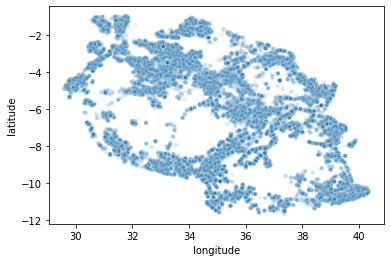

In [14]:
sns.scatterplot(x="longitude", y="latitude", size = 1, alpha = 0.1, data=df, legend=False)

plt.show()

This looks like Tanzania. I'll later use these to calculate distance to other key elements.

## Num_private
there's no information on what this value is. Most values have 0 with a handful outliers. I'll see more in detail how this influences our model during model evaluation.

In [15]:
#df.num_private.value_counts()

## Construction year
(since we have many 0 values, I will only look at ones not 0)

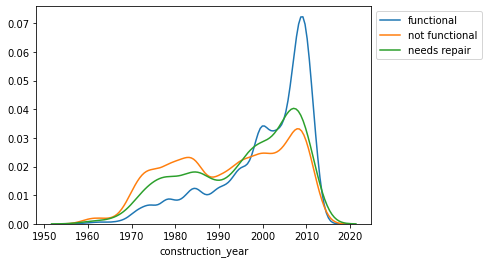

In [16]:
tmp = df[df.construction_year!=0]
sns.distplot(tmp[tmp.status_group == 'functional'].construction_year, hist = False, 
            label='functional')
sns.distplot(tmp[tmp.status_group == 'non functional'].construction_year, hist = False, 
            label = 'not functional')
sns.distplot(tmp[tmp.status_group == 'functional needs repair'].construction_year, hist = False, 
            label = 'needs repair')

plt.legend(bbox_to_anchor = [1, 1])
plt.show()
                 

most functional wells are built recently.

Since construction year data seems important but mostly missing. I'm going to turn this into a binary column that indicates whether it was built in 2000s or before.

In [67]:
df['built_recent'] = np.where(df.construction_year > 2000, 1, 0)

## Population
Most values are 0, but since many are 1, I'm guessing this means that most wells are far from the residential areas.

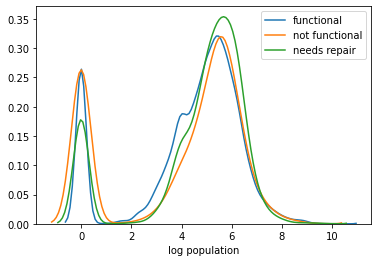

In [17]:
tmp = df[df.population!=0]
sns.distplot(np.log(tmp[tmp.status_group == 'functional'].population), hist = False, 
            label='functional')
sns.distplot(np.log(tmp[tmp.status_group == 'non functional'].population), hist = False, 
            label = 'not functional')
sns.distplot(np.log(tmp[tmp.status_group == 'functional needs repair'].population), hist = False, 
            label = 'needs repair')

plt.xlabel('log population')
plt.legend(bbox_to_anchor = [1, 1])
plt.show()
                 

## Categorical values
Now I will look at other categorical values.

In [18]:
len(set(df.installer)) == len(set([x.lower() for x in df.installer]))

False

It seems like I need to turn all texts into lower case in order to account for any text mishaps.

In [19]:
text_feats = ['funder', 'installer', 'wpt_name', 'basin', 
 'subvillage', 'region', 'lga', 'ward', 'recorded_by', 
 'scheme_management', 'scheme_name', 'extraction_type',
 'extraction_type_group', 'extraction_type_class', 'management',
 'management_group', 'payment', 'payment_type', 'water_quality',
 'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
 'source_class', 'waterpoint_type', 'waterpoint_type_group']

for c in text_feats:
    df[c] = [x.lower() for x in df[c]]

### Categories
Most categorical values are strings, and it can confuse pandas. so I'll transform them into categories.

In [20]:
categories = list(df.select_dtypes('object').columns)
df[categories] = df[categories].astype('category')

Additionally quantity and quantity_group seems to be the same thing so I will remove quantity_group.

In [21]:
# df[df.quantity != df.quantity_group]
colstodrop = colstodrop + ['quantity_group']

### Funder & Installer
There are many funder and installers. Turning all of them as a dummy is computationally expensive. Instead I'll group values that have less than 3 values into others. (only 3 observation isn't really generalizable.)

In [22]:
other_funders = df.funder.unique()[df.funder.value_counts() <= 3]
df['funder'] = np.where(df.funder.isin(other_funders), 'others', df.funder)

In [23]:
other_installer = df.installer.unique()[df.installer.value_counts() <= 3]
df['installer'] = np.where(df.installer.isin(other_installer), 'others', df.installer)

## WPT Name
I can't really think of any possible reason waterpoint name has anything to do with the target. So I'll remove this column.

In [24]:
colstodrop = colstodrop + ['wpt_name']

## Locations
There are several location information. basin, subvillage, region, region_code, district_code, lga, ward. I want to turn some of these into lat/long so I can calculate the distance to the basin and to the town.

In [27]:
from geopy.geocoders import Nominatim

def get_lat_long(location):
    geolocator = Nominatim(user_agent = "Tanzwater")
    location = geolocator.geocode(location)
    return (location.latitude, location.longitude)

### Basins

In [30]:
basins = set(df.basin)
allbasins = dict.fromkeys(basins, ())
for bas in basins:
    try:
        allbasins[bas] = get_lat_long(bas)
    except AttributeError:
        print(f'error: {bas}')

error: wami / ruvu
error: ruvuma / southern coast


In [34]:
# manually adding ones that threw error
allbasins['wami / ruvu'] = (-6.8176, 37.6604)
allbasins['ruvuma / southern coast'] = (-11.25, 38.31)

In [39]:
df['basin_lat'] = df.basin.apply(lambda x: allbasins[x][0])
df['basin_long'] = df.basin.apply(lambda x: allbasins[x][1])

### LGA 
I think this is district (within regions).

In [41]:
lgas = set(df.lga)
alllgas = dict.fromkeys(lgas, ())
for lg in lgas:
    try:
        alllgas[lg] = get_lat_long(lg)
    except AttributeError:
        print(f'error: {lg}')

error: mtwara urban
error: lindi urban
error: missungwi
error: songea urban
error: singida urban
error: arusha urban


In [49]:
# manually adding ones that threw error
alllgas['mtwara urban'] = get_lat_long('mtwara')
alllgas['lindi urban'] = get_lat_long('lindi')
alllgas['missungwi'] = (-2.8403, 33.0851)
alllgas['songea urban'] = get_lat_long('songea')
alllgas['singida urban'] = get_lat_long('singida')
alllgas['arusha urban'] = get_lat_long('arusha')

In [50]:
df['lga_lat'] = df.lga.apply(lambda x: alllgas[x][0])
df['lga_long'] = df.lga.apply(lambda x: alllgas[x][1])

## New Features: Distance 
### Distance to Basin / Distance to LGA
I'll calculate the distance to basin and LGA using Lat/Long

In [72]:
from geopy.distance import geodesic

def get_dist(crd1, crd2): 
    return geodesic(crd1, crd2).miles


In [85]:
df['dist_to_lga'] = df.apply(lambda x: get_dist((x.latitude, x.longitude), 
                            (x.lga_lat, x.lga_long)), axis = 1)

df['dist_to_basin'] = df.apply(lambda x: get_dist((x.latitude, x.longitude), 
                            (x.basin_lat, x.basin_long)), axis = 1)

In [ ]:
colstodrop = colstodrop + ['waterpoint_type_group']

## Waterpoint type vs. Waterpoint type group
I'll take a look at the difference between waterpoint type and waterpoint type group.

In [ ]:
# waterpoint_type
ct = pd.crosstab(df['status_group'], df['waterpoint_type'],normalize = True)
sns.heatmap(ct, annot=True,  fmt = '.1f', linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()

# waterpoint_type_group
ct = pd.crosstab(df['status_group'], df['waterpoint_type_group'],normalize = True)
sns.heatmap(ct, annot=True,  fmt = '.1f', linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()


It seems like overall trend is the same, except for the waterpoint type divided the communal standpipe to two categories. I should probably just use waterpoint type and not waterpoint type group. Since subgroup changes the pattern slightly.

### Extraction type, group, class
There are extraction type and group and class. Let's see how they differ.

In [ ]:
# extraction_type
ct = pd.crosstab(df['status_group'], df['extraction_type'],normalize = True)
sns.heatmap(ct, annot=True,  fmt = '.1f', linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()

# extraction_type_group
ct = pd.crosstab(df['status_group'], df['extraction_type_group'],normalize = True)
sns.heatmap(ct, annot=True, fmt = '.2f', linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()

# extraction_type_class
ct = pd.crosstab(df['status_group'], df['extraction_type_class'],normalize = True)
sns.heatmap(ct, annot=True, fmt = '.2f', linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()



Again it seems like a same information but different scale of grouping. Types have some classes with 0 values so not all cases might be helpful. It's hard to determine which one should we keep. But to minimize complexity. I'll keep the class and later possibly add in some of the smaller subset that seem to show some importance.

In [ ]:
colstodrop = colstodrop + ['extraction_type_group', 'extraction_type']

### Payment  vs. Payment type
Also looking at how payment and payment type differs.

In [ ]:
# waterpoint_type
ct = pd.crosstab(df['status_group'], df['payment'],normalize = True)
sns.heatmap(ct, annot=True,  fmt = '.1f', linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()

# waterpoint_type_group
ct = pd.crosstab(df['status_group'], df['payment_type'],normalize = True)
sns.heatmap(ct, annot=True,  fmt = '.1f', linewidths=.5, cbar = False, cmap="Blues")
plt.xlabel('')
plt.ylabel('')
plt.show()


Payment and payment type seem to be same values with slightly different labeling convention.

In [ ]:
colstodrop = colstodrop + ['payment']

## Useless columns
additionally, who collects the data is not a good predictor of the well condition (recorded_by), also the name of a person operating the waterpoint is not as important as the management. So I'll drop these columns.

In [86]:
colstodrop = colstodrop + ['scheme_name', 'recorded_by']

In [ ]:
df = df.drop(colstodrop, axis = 1)

# Feature Engineering

Before I begin, I'm going to split the dataset here, and build a preliminary model to compare. I'll use a logistic regression as a base model.

In [ ]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score

y = df['status_group']
X = df.drop('status_group', axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
# One Hot Encoding 
X_train_ohe = pd.get_dummies(X_train)

In [ ]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

def logreg_test(X, y):
    logreg = LogisticRegression(class_weight='balanced', random_state = 10)
    cv = KFold(n_splits = 5, shuffle = True, random_state = 20)
    score = np.mean(cross_val_score(logreg, X, y, scoring = 'roc_auc', cv = cv, 
                                    n_jobs = -1, verbose = 1))
    return score

In [ ]:
# checking available scorers
from sklearn.metrics import SCORERS
#sorted(SCORERS.keys())

In [ ]:
logreg_test(X_train_ohe, y_train)